# Develop a good model

> - 1. implement relevant metrics to weights and biases so that improvements can be clearly seen from one run to the next. This should include:
> - Log of charts
> - Log of hyperparameters


> - 2. Train a model using 20% of the unverified training set
> - 3. Use this model to make predictions on the rest of the training set
> - 4. Clean the training data of any mis-labels buy looking at top losses
> - 5. Re-train the model on the cleaned training set. 
> - 6. Iterate through different settings to reach an acceptable performance. 


In [11]:
description = "train with human labelled samples only"

In [12]:
# autoreload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
!wandb login

wandb: Currently logged in as: mgallimore88. Use `wandb login --relogin` to force relogin


In [14]:
# imports
from pathlib import Path
import sys
import pandas as pd
BASE_PATH = Path.cwd().parent.parent
sys.path.append(str(BASE_PATH))
import src.data
import src.data.build
import opensoundscape as opso
from opensoundscape.preprocess.utils import show_tensor, show_tensor_grid
import numpy as np
import hashlib
model_save_path = BASE_PATH / 'models'
import matplotlib.pyplot as plt
import torch
from utils import plot_metrics_across_thresholds
from opensoundscape.data_selection import resample




# Set some hyperparameters

In [10]:
n_samples_per_class = 800
one_output_neuron = True
random_seed = 46
learning_rate = 0.0001
epochs=15

### Load the datasets
The original input csv needs processing so that the audio samples are multi - indexed by filename, start_time and end_time, and features were created indicating whether these clips contain a call of the target species. 



In [7]:
# # optionally load the multi-indexed datasets from disk
data_path = Path.cwd().parent.parent / "data"
train_df = pd.read_pickle(data_path / "interim" / "train_set" / "train_df.pkl")
valid_df = pd.read_pickle(data_path / "interim" / "valid_set" / "valid_df.pkl")

# Or build from an input dataframe with clip id as the index. 
# train_dataset, valid_dataset, _, _ = src.data.build.dataset_from_df(train_df, target_species = "OSFL", download_n=0, seed=random_seed)
# train_df = train_dataset.label_df
# valid_df = valid_dataset.label_df

# # train_df.to_pickle(data_path / "interim" / "train_set" / "train_df.pkl")
# # valid_df.to_pickle(data_path / "interim" / "valid_set" / "valid_df.pkl")

# Load focal recordings and split into train and valid sets
The focal recordings are predictions made by HawkEars - an existing multi species recognizer. The model was run on the audio recordings in the training and validation sets - and the top 2% of results were returned to be used as training data.

The validation detections need separating from the training detections because we want to see how well the model performs in new locations. 

In [9]:
focal_recs = pd.read_pickle(data_path / "interim" / "train_and_valid_set" /"focal_osfls_thresh_0.99_ngen_1038.pkl")

# Convert the focal df index to Path objects
new_index = focal_recs.index.set_levels(focal_recs.index.levels[0].map(Path), level=0)

# Split the focal clips into train and valid sets by filtering by the file paths at index of each dataset. 
focal_recs.index = new_index

# Find the audio recording file paths used for each dataframe
train_df_file_paths = train_df.index.get_level_values('file')
valid_df_file_paths = valid_df.index.get_level_values('file')
focal_recs_file_paths = focal_recs.index.get_level_values('file')

# Split the focal recordings into train and valid sets
train_focal_recs_idx = focal_recs_file_paths.isin(train_df_file_paths)
valid_focal_recs_idx = focal_recs_file_paths.isin(valid_df_file_paths)

train_focal = focal_recs[train_focal_recs_idx]
valid_focal = focal_recs[valid_focal_recs_idx]
train_focal

recording_id  \
file                                               start_time end_time                 
../../data/raw/recordings/OSFL/recording-555135... 6.0        9.0             555135   
                                                   7.5        10.5            555135   
                                                   13.5       16.5            555135   
                                                   15.0       18.0            555135   
                                                   24.0       27.0            555135   
...                                                                              ...   
../../data/raw/recordings/OSFL/recording-293120... 121.5      124.5           293120   
                                                   124.5      127.5           293120   
                                                   154.5      157.5           293120   
                                                   156.0      159.0           293120   
../../data/raw/recordings/OSFL/recording-556648... 37.5       40.5            556648   

                                                                       label  \
file                                               start_time end_time         
../../data/raw/recordings/OSFL/recording-555135... 6.0        9.0       OSFL   
                                                   7.5        10.5      OSFL   
                                                   13.5       16.5      OSFL   
                                                   15.0       18.0      OSFL   
                                                   24.0       27.0      OSFL   
...                                                                      ...   
../../data/raw/recordings/OSFL/recording-293120... 121.5      124.5     OSFL   
                                                   124.5      127.5     OSFL   
                                                   154.5      157.5     OSFL   
                                                   156.0      159.0     OSFL   
../../data/raw/recordings/OSFL/recording-556648... 37.5       40.5      OSFL   

                                                                       score  \
file                                               start_time end_time         
../../data/raw/recordings/OSFL/recording-555135... 6.0        9.0       0.99   
                                                   7.5        10.5      0.99   
                                                   13.5       16.5      0.98   
                                                   15.0       18.0      0.99   
                                                   24.0       27.0      0.98   
...                                                                      ...   
../../data/raw/recordings/OSFL/recording-293120... 121.5      124.5     0.98   
                                                   124.5      127.5     0.98   
                                                   154.5      157.5     0.98   
                                                   156.0      159.0     0.98   
../../data/raw/recordings/OSFL/recording-556648... 37.5       40.5      0.98   

                                                                       file_extension  \
file                                               start_time end_time                  
../../data/raw/recordings/OSFL/recording-555135... 6.0        9.0                flac   
                                                   7.5        10.5               flac   
                                                   13.5       16.5               flac   
                                                   15.0       18.0               flac   
                                                   24.0       27.0               flac   
...                                                                               ...   
../../data/raw/recordings/OSFL/recording-293120... 121.5      124.5               mp3   
                                            

When the human labelled tags are made, the listeners only tag the first vocalization of an individual within a time period. This isn't usually the most prominent vocalization of that individual. The focal recordings allow us to reach further into the recording - past the first vocalization - use take most prominent and clear calls. 

In [44]:
train_df.value_counts(), len(train_focal)

(target_absence  target_presence
 1.0             0.0                45081
 0.0             1.0                 4211
 Name: count, dtype: int64,
 960)

# Available data
There are 4211 human labelled present samples and 45081 absent samples avaliable for training. 

There are also 960 focal OSFL calls found further into the training recordings 

The human labelled samples start out containing some mis-labelled data. This needs to be cleaned, and one way to do this is to make predictions on the training data then sort these by error, then go through and re-label any absence clips which contain the target, or any present labels which don't. 



We can test the effect of mixing in extra samples by either:
- completely replacing the training present samples with focal ones
- mixing them in in ratios

### Make a hash of the dataset. 
To compare one run with another, the datasets need to contain the same samples.  
The random seed sets the deterministic splitting of the training and validation set. Here we can check whether the splits have changed from one run to the next. 

In [10]:
def get_hash_from_df(df):
    '''
    Convert the DataFrame to a hashable string.
    Take a hash of each row, then concatenate the hashes, and finally hash the concatenated hash.
    '''
    df_string_to_hash = ''.join(pd.util.hash_pandas_object(df, index=False).astype(str))

    # Use hashlib to create a hash of the entire DataFrame
    df_hash_value = hashlib.sha256(df_string_to_hash.encode()).hexdigest()

    print(df_hash_value)
    return df_hash_value

train_hash_value = get_hash_from_df(train_df)
valid_hash_value = get_hash_from_df(valid_df)

28029fc6efcdec044c3d4e7c9412a882bbfc680b33c966290529f7ed8c5956b2
7ae7ebc16edad82fdc43102630d180e6fa3b4a32e44a0cc64ca70ab68ec0d1fe


In [11]:
# These are just copied from the output of the above cell. If the dataset changes, an error will be raised. 
assert train_hash_value == "28029fc6efcdec044c3d4e7c9412a882bbfc680b33c966290529f7ed8c5956b2", "Training set has changed"
assert valid_hash_value == "7ae7ebc16edad82fdc43102630d180e6fa3b4a32e44a0cc64ca70ab68ec0d1fe", "Validation set has changed"

In [12]:
# upsample (repeat samples) or downsample so that both classes have equal numbers of samples

balanced_train_df = resample(train_df,n_samples_per_class=n_samples_per_class,random_state=random_seed)
balanced_valid_df = resample(valid_df,n_samples_per_class=500,random_state=random_seed)

# # drop the redundant absence column
balanced_train_df = balanced_train_df.drop(columns=["target_absence"])

balanced_valid_df = balanced_valid_df.drop(columns=["target_absence"])

balanced_train_df.target_presence.value_counts(), len(balanced_train_df)

(target_presence
 0.0    960
 1.0    960
 Name: count, dtype: int64,
 1920)

# Combine the absent samples from train_df with the focal samples


In [13]:
train_focal.head()

recording_id  \
file                                               start_time end_time                 
../../data/raw/recordings/OSFL/recording-555135... 6.0        9.0             555135   
                                                   7.5        10.5            555135   
                                                   15.0       18.0            555135   
                                                   40.5       43.5            555135   
                                                   42.0       45.0            555135   

                                                                       label  \
file                                               start_time end_time         
../../data/raw/recordings/OSFL/recording-555135... 6.0        9.0       OSFL   
                                                   7.5        10.5      OSFL   
                                                   15.0       18.0      OSFL   
                                                   40.5       43.5      OSFL   
                                                   42.0       45.0      OSFL   

                                                                       score  \
file                                               start_time end_time         
../../data/raw/recordings/OSFL/recording-555135... 6.0        9.0       0.99   
                                                   7.5        10.5      0.99   
                                                   15.0       18.0      0.99   
                                                   40.5       43.5      1.00   
                                                   42.0       45.0      1.00   

                                                                       file_extension  \
file                                               start_time end_time                  
../../data/raw/recordings/OSFL/recording-555135... 6.0        9.0                flac   
                                                   7.5        10.5               flac   
                                                   15.0       18.0               flac   
                                                   40.5       43.5               flac   
                                                   42.0       45.0               flac   

                                                                        duration  
file                                               start_time end_time            
../../data/raw/recordings/OSFL/recording-555135... 6.0        9.0            3.0  
                                                   7.5        10.5           3.0  
                                                   15.0       18.0           3.0  
                                                   40.5       43.5           3.0  
                                                   42.0       45.0           3.0

### Option 1 - Combine the absent samples from balanced_train_df with focal samples as present class

In [14]:
absent = balanced_train_df.loc[train_df.target_presence == 0]
# absent.drop(columns=["target_absence"], inplace=True)
train_focal["target_presence"] = 1.0
train_focal = train_focal[["target_presence"]]
focal_train_df = pd.concat([absent, train_focal])
focal_train_df.value_counts()

/var/folders/hy/36n7jr6x3h74ddx507dc12_00000gn/T/ipykernel_61590/1610866874.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_focal["target_presence"] = 1.0


target_presence
0.0                960
1.0                960
Name: count, dtype: int64

### Option 2: combine absent samples from the training set with focal samples and human labelled samples. 

In [15]:
# mix in equal amounts of focal and non focal present samples with 2 x absent samples
absent = train_df.loc[train_df.target_presence == 0].sample(len(balanced_train_df), random_state=random_seed)
present = balanced_train_df.loc[balanced_train_df.target_presence == 1]
absent.drop(columns=["target_absence"], inplace=True)


# downsample from each class
factor = 1
absent = absent.sample(n_samples_per_class*2, random_state=random_seed)
present = present.sample(n_samples_per_class, random_state=random_seed)
train_focal = train_focal.sample(n_samples_per_class, random_state=random_seed)


train_focal["target_presence"] = 1.0
train_focal = train_focal[["target_presence"]]
shuffled_mixed_train_df = pd.concat([absent, present, train_focal]).sample(frac=1) # shuffle
shuffled_mixed_train_df.value_counts()

target_presence
0.0                1920
1.0                1920
Name: count, dtype: int64

### Shuffle the datasets since the resampling method sorts the data. 

In [16]:
shuffled_focal_train_df = focal_train_df.sample(frac=1, random_state=random_seed)
shuffled_balanced_train_df = balanced_train_df.sample(frac=1)
shuffled_balanced_valid_df = balanced_valid_df.sample(frac=1)

In [17]:
balanced_train_df.columns, balanced_valid_df.columns, focal_train_df.columns

(Index(['target_presence'], dtype='object'),
 Index(['target_presence'], dtype='object'),
 Index(['target_presence'], dtype='object'))

# Define the model

In [18]:
# Create a CNN object designed to recognize 3-second samples
from opensoundscape import CNN

# Use resnet18 or resnet34 architecture
architecture = 'resnet34'

# Can use this code to get your classes, if needed
class_list = list(shuffled_mixed_train_df.columns)

model = CNN(
    architecture = architecture,
    classes = class_list,
    sample_duration=3,
)
# Single target means that the label can't be present and absent simultaneously. For multi class problems this could be set to true, but for a binary problem it should be false.
model.single_target = False

# model.lr_cooling_factor = 0.1
# model.lr_update_interval = 1
model.classes

['target_presence']

Or load a pretrained model from disk for further training

In [19]:
# opso.cnn.load_model(model_save_path / 'first_focal_unbalanced2024-03-12.model') 

In [20]:
model.optimizer_params['lr'] = learning_rate

In [21]:
model.network.fc

Linear(in_features=512, out_features=1, bias=True)

In [22]:
def show_sample_from_df(present=True, df = balanced_train_df):
    if present:
        present = 1
    else: 
        present = 0
    sample = df.loc[df.target_presence == present].sample()
    path, offset, end_time = sample.index[0]
    duration = end_time - offset
    audio = opso.Audio.from_file(path, offset=offset, duration=duration)
    spec = opso.Spectrogram.from_audio(audio)
    audio.show_widget()
    spec.plot()


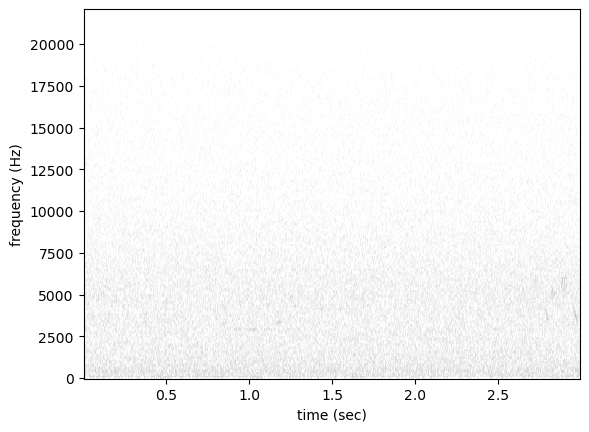

In [23]:
show_sample_from_df(present=False, df = shuffled_mixed_train_df)

In [24]:
print(f'model.device is: {model.device}')

model.device is: mps


In [25]:
%set_env WANDB_NOTEBOOK_NAME="1.15.1-mjg-osfl-revisit-opso-training-cycle"

env: WANDB_NOTEBOOK_NAME="1.15.1-mjg-osfl-revisit-opso-training-cycle"


# Weights and biases initialization

In [26]:
import wandb
wandb.login()

wandb_session = wandb.init(

    project='OSFL',
    notes=description,
    config={
    "epochs":epochs,
    "n_samples_per_class": n_samples_per_class,
    "one_output_neuron": one_output_neuron,
    "random_seed": random_seed,
    # "positive_index": positive_index,
    "balanced_valid_set": True,
    
    }
)
wandb.config.learning_rate = learning_rate



wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find "1.15.1-mjg-osfl-revisit-opso-training-cycle".
wandb: Currently logged in as: mgallimore88. Use `wandb login --relogin` to force relogin
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


In [27]:
epochs

15

In [28]:
shuffled_mixed_train_df.value_counts()

target_presence
0.0                1920
1.0                1920
Name: count, dtype: int64

In [29]:
# Loop 1 on the first balanced training set
model.train(
    shuffled_mixed_train_df,
    shuffled_balanced_valid_df,
    epochs = epochs,
    batch_size = 64,
    num_workers = 0, # main /no parallelized cpu tasks for preprocessing
    log_interval = 100,
    save_interval = 1,
    save_path=model_save_path,
    wandb_session = wandb_session,
    )


Training Epoch 0


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch: 0 [batch 0/60, 0.00%] 
	DistLoss: 0.823
Metrics:
Metrics:
	MAP: 0.671

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:
	MAP: 0.643

Training Epoch 1


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch: 1 [batch 0/60, 0.00%] 
	DistLoss: 0.557
Metrics:
Metrics:
	MAP: 0.821

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:
	MAP: 0.731

Training Epoch 2


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch: 2 [batch 0/60, 0.00%] 
	DistLoss: 0.567
Metrics:
Metrics:
	MAP: 0.863

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:
	MAP: 0.815

Training Epoch 3


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch: 3 [batch 0/60, 0.00%] 
	DistLoss: 0.480
Metrics:
Metrics:
	MAP: 0.886

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:
	MAP: 0.841

Training Epoch 4


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch: 4 [batch 0/60, 0.00%] 
	DistLoss: 0.439
Metrics:
Metrics:
	MAP: 0.910

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:
	MAP: 0.867

Training Epoch 5


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch: 5 [batch 0/60, 0.00%] 
	DistLoss: 0.418
Metrics:
Metrics:
	MAP: 0.923

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:
	MAP: 0.890

Training Epoch 6


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch: 6 [batch 0/60, 0.00%] 
	DistLoss: 0.405
Metrics:
Metrics:
	MAP: 0.930

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:
	MAP: 0.909

Training Epoch 7


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch: 7 [batch 0/60, 0.00%] 
	DistLoss: 0.293
Metrics:
Metrics:
	MAP: 0.931

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:
	MAP: 0.905

Training Epoch 8


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch: 8 [batch 0/60, 0.00%] 
	DistLoss: 0.406
Metrics:
Metrics:
	MAP: 0.937

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:
	MAP: 0.925

Training Epoch 9


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch: 9 [batch 0/60, 0.00%] 
	DistLoss: 0.434
Metrics:
Metrics:
	MAP: 0.942

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:
	MAP: 0.926

Training Epoch 10


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch: 10 [batch 0/60, 0.00%] 
	DistLoss: 0.413
Metrics:
Metrics:
	MAP: 0.946

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:
	MAP: 0.932

Training Epoch 11


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch: 11 [batch 0/60, 0.00%] 
	DistLoss: 0.291
Metrics:
Metrics:
	MAP: 0.949

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:
	MAP: 0.936

Training Epoch 12


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch: 12 [batch 0/60, 0.00%] 
	DistLoss: 0.352
Metrics:
Metrics:
	MAP: 0.949

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:
	MAP: 0.936

Training Epoch 13


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch: 13 [batch 0/60, 0.00%] 
	DistLoss: 0.202
Metrics:
Metrics:
	MAP: 0.949

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:
	MAP: 0.934

Training Epoch 14


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch: 14 [batch 0/60, 0.00%] 
	DistLoss: 0.398
Metrics:
Metrics:
	MAP: 0.953

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:
	MAP: 0.937

Best Model Appears at Epoch 14 with Validation score 0.937.


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/ml/safe_dataset.py:133: UserWarning: There were 1 sample(s) that raised errors and were skipped.The invalid file paths are logged in ./invalid_training_samples.log
  warnings.warn(msg)


In [30]:
# # Loop 2 on the first balanced training set
# model.train(
#     shuffled_focal_train_df,
#     shuffled_balanced_valid_df,
#     epochs = 2,
#     batch_size = 64,
#     num_workers = 4, #4 parallelized cpu tasks for preprocessing
#     log_interval = 100,
#     save_interval = 10,
#     wandb_session = wandb_session,
#     )

# Adding a second training set reduced validation score. 

# Too good to be true?
Load the results into notebook 1.21 for sanity check

In [31]:
# save the model too
import datetime
dt = datetime.datetime.now().isoformat()
best_model = opso.cnn.load_model("best.model")
best_model.save(model_save_path / f"osfl_model_1038_focal_45081_absent{dt}")

# Show metrics

In [32]:
model.train_metrics

{0: {'target_presence': {'au_roc': 0.6361793717934494,
   'avg_precision': 0.6712405646986896,
   'precision': 0.5600535296085647,
   'recall': 0.8714211348256117,
   'f1': 0.6818737270875764,
   'support': 1921},
  'precision': 0.6349033805504634,
  'recall': 0.593084199512858,
  'f1': 0.5589874050600336,
  'jaccard': 0.39808017376079585,
  'hamming_loss': 0.40677083333333336,
  'map': 0.6712405646986896,
  'au_roc': 0.6361793717934494},
 1: {'target_presence': {'au_roc': 0.7738362016699765,
   'avg_precision': 0.8205474644322501,
   'precision': 0.6483952398124775,
   'recall': 0.9359708485163977,
   'f1': 0.766084363016617,
   'support': 1921},
  'precision': 0.7665593818556296,
  'recall': 0.7139468625072869,
  'f1': 0.6991841774895542,
  'jaccard': 0.5415741121530727,
  'hamming_loss': 0.2859375,
  'map': 0.8205474644322501,
  'au_roc': 0.7738362016699765},
 2: {'target_presence': {'au_roc': 0.8261674875671354,
   'avg_precision': 0.8632348450076703,
   'precision': 0.690092165898

In [33]:
model.valid_metrics

{0: {'target_presence': {'au_roc': 0.633104,
   'avg_precision': 0.6432074132420841,
   'precision': 0.5361803084223014,
   'recall': 0.904,
   'f1': 0.673119880863738,
   'support': 500},
  'precision': 0.6152239121729342,
  'recall': 0.561,
  'f1': 0.5024655720909252,
  'jaccard': 0.3531001417254459,
  'hamming_loss': 0.439,
  'map': 0.6432074132420841,
  'au_roc': 0.633104},
 1: {'target_presence': {'au_roc': 0.709392,
   'avg_precision': 0.7306951678680299,
   'precision': 0.6075581395348837,
   'recall': 0.836,
   'f1': 0.7037037037037038,
   'support': 500},
  'precision': 0.6723688133571855,
  'recall': 0.648,
  'f1': 0.6351030833789455,
  'jaccard': 0.4690230731467845,
  'hamming_loss': 0.352,
  'map': 0.7306951678680299,
  'au_roc': 0.709392},
 2: {'target_presence': {'au_roc': 0.7820480000000001,
   'avg_precision': 0.8145863230677256,
   'precision': 0.6661490683229814,
   'recall': 0.858,
   'f1': 0.75,
   'support': 500},
  'precision': 0.7333554330378952,
  'recall': 0.71

In [34]:
# load the best model
# best_model = opso.cnn.load_model("best.model")

# Confusion matrix on balanced validation set 
There are equal numbers of examples from each class. 

  0%|          | 0/1000 [00:00<?, ?it/s]

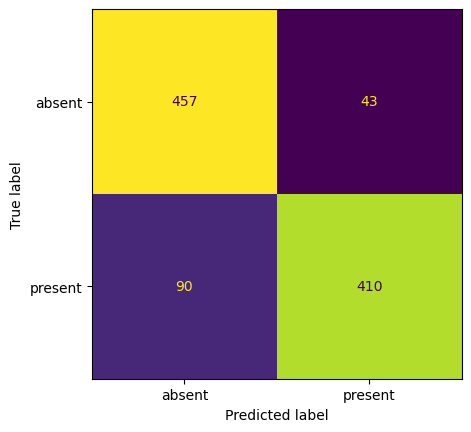

In [35]:
def model_to_cm(model, df):
    shuf_preds = model.predict(df)
    shuf_preds['sigmoid_prediction'] = torch.sigmoid(torch.tensor(shuf_preds.target_presence.values))
    scores = shuf_preds.sigmoid_prediction.values
    targets = df.target_presence.values
    cm = opso.metrics.M.confusion_matrix(targets, scores.round())
    cm_display = opso.metrics.M.ConfusionMatrixDisplay(cm, display_labels=['absent', 'present'])
    cm_display.plot(colorbar=False)
    return scores, targets

scores, targets = model_to_cm(model, shuffled_balanced_valid_df)


Using only focal samples for the present class has the effect of increasing precision at the expense of recall. This is for a threshold of 0.5, so other thresholds should be tried. 

# Make predictions on the full validation set
during training we only looked at a subset of the validation set values. 

In [36]:
cleaned_valid_df = pd.read_pickle(data_path / "interim" / "valid_set" / "valid_df_verified.pkl")
# Remove the 'discard' samples from the validation set
cleaned_valid_df.drop(cleaned_valid_df.loc[cleaned_valid_df.confidence_cat == 1].index, inplace=True)

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/ml/cnn.py:201: UserWarning: The columns of input samples df differ from `model.classes`.
  warnings.warn(


  0%|          | 0/10694 [00:00<?, ?it/s]

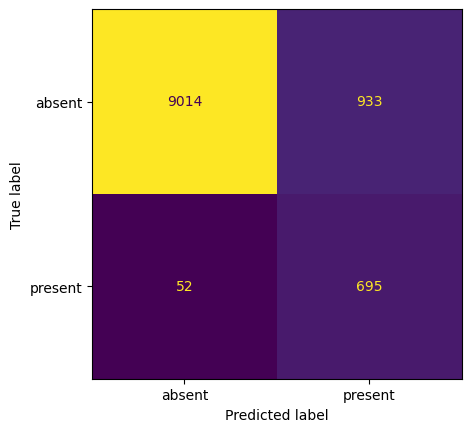

In [37]:
scores, targets = model_to_cm(model, cleaned_valid_df)

In [38]:
wandb.sklearn.plot_confusion_matrix(targets, scores.round(), ["absent", "present"])

# Look at the metrics across thresholds

In [39]:
# autoreload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


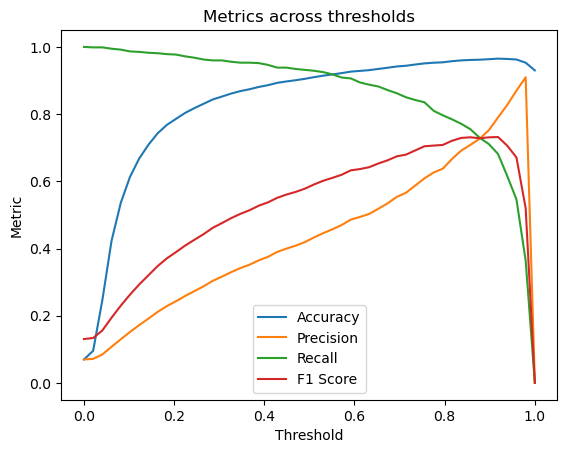

In [40]:
plot_data, legend = plot_metrics_across_thresholds(pd.DataFrame({"label":targets, "present_pred":scores}))

thresholds, accuracies, precisions, recalls, f1s = zip(*list(plot_data))

In [41]:
wandb.log(
    {
        "metrics": wandb.plot.line_series(
            xs= [thresholds, thresholds, thresholds, thresholds],
            ys=[accuracies, precisions, recalls, f1s],
            keys=legend,
            title="Metrics across thresholds",
            xname="threshold",
        )
    }
)

In [42]:
def log_single_metric(metric, name):
    data = [[x, y] for (x, y) in zip(thresholds, metric)]
    table = wandb.Table(data=data, columns=["x", "y"])
    wandb.log(
        {
            f"custom {name}": wandb.plot.line(
                table, "x", "y", title=f"Custom {name} vs threshold plot"
            )
        }
    )
log_single_metric(accuracies, "accuracy")
log_single_metric(precisions, "precision")
log_single_metric(recalls, "recall")
log_single_metric(f1s, "f1")


# Result: 


# Save the best model

In [51]:
date_time_id = dt
model_name = "caramel-mousse_1920_absent_960_present_960_focal"
model.save(model_save_path / f"{model_name}_{date_time_id}")
# best_model = opso.cnn.load_model("best.model")
# best_model.save(model_save_path / f"{model_name}_{date_time_id}")

# Export the index of the dataset used for training

In [52]:
! mkdir -p {model_save_path / "training_indices"}
shuffled_mixed_train_df.to_pickle(model_save_path / "training_indices" / f"seed_{random_seed}_{model_name}_{date_time_id}.pkl")

In [44]:

wandb.finish()


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:89: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▆▅▄▃▂▂▂▂▂▁▁▁▁▁
epoch,14
loss,0.29451


In [45]:
model.save(model_save_path / f"balanced_mixed_1920_crashed_lr0008{dt}.model")